In [ ]:
# ==============================
# FEATURE EXTRACTION EXPERIMENT
# ==============================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import pickle
import os
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ---------------------------
# 1. DEFINE DATA VARIATIONS
# ---------------------------

# Resize to 224x224 for ResNet
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

normalize = transforms.Normalize((0.5,), (0.5,))

normalized_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    normalize
])

# Dataset dictionary
transform_variations = {
    "Base": base_transform,
    "Normalized": normalized_transform,
    "Normalized + Augment": augment_transform,
    "Normalized + Augment + Regularize": augment_transform  # regularization in model, not transform
}

# ---------------------------
# 2. TRAINING & EVALUATION LOOP
# ---------------------------

def train_feature_extraction(model, train_loader, val_loader, epochs=10, lr=1e-3, regularize=False, history=None):
    # Freeze all layers except final classifier
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=1e-3 if regularize else 0.0)

    # Create history if not provided
    if history is None:
        history = {"train_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute training accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        val_acc, _, _ = evaluate(model, val_loader)

        # Append to history
        history["train_loss"].append(avg_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    return history



def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    acc = 100 * correct / total
    return acc, np.array(all_preds), np.array(all_labels)



In [ ]:
print(device)

cuda


In [ ]:
# ---------------------------
# 3. GRAD-CAM IMPLEMENTATION
# ---------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach().clone()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        loss = output[0, target_class]
        loss.backward()

        if self.gradients is None:
            raise RuntimeError("Gradients were not captured. Check target_layer or hooks.")

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        cam = cam.cpu().numpy()
        return cam, target_class



🔹 Running Base dataset
Epoch [1/8] - Loss: 0.5696 | Train Acc: 86.72% | Val Acc: 93.68%
Epoch [2/8] - Loss: 0.2329 | Train Acc: 93.91% | Val Acc: 94.51%
Epoch [3/8] - Loss: 0.1851 | Train Acc: 94.79% | Val Acc: 95.23%
Epoch [4/8] - Loss: 0.1630 | Train Acc: 95.33% | Val Acc: 95.18%
Epoch [5/8] - Loss: 0.1476 | Train Acc: 95.75% | Val Acc: 95.83%
Epoch [6/8] - Loss: 0.1373 | Train Acc: 95.96% | Val Acc: 96.02%
Epoch [7/8] - Loss: 0.1291 | Train Acc: 96.21% | Val Acc: 96.01%
Epoch [8/8] - Loss: 0.1240 | Train Acc: 96.30% | Val Acc: 96.03%
✅ Base Test Accuracy: 96.31%


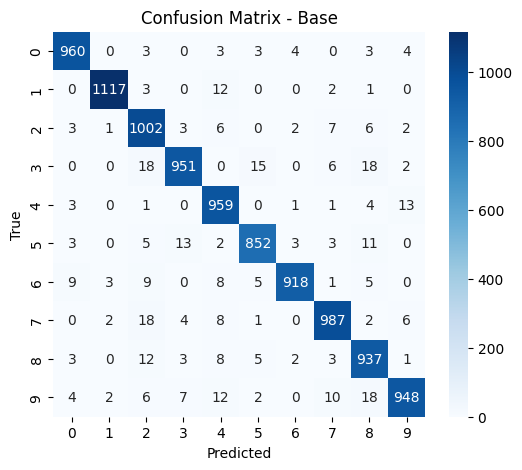

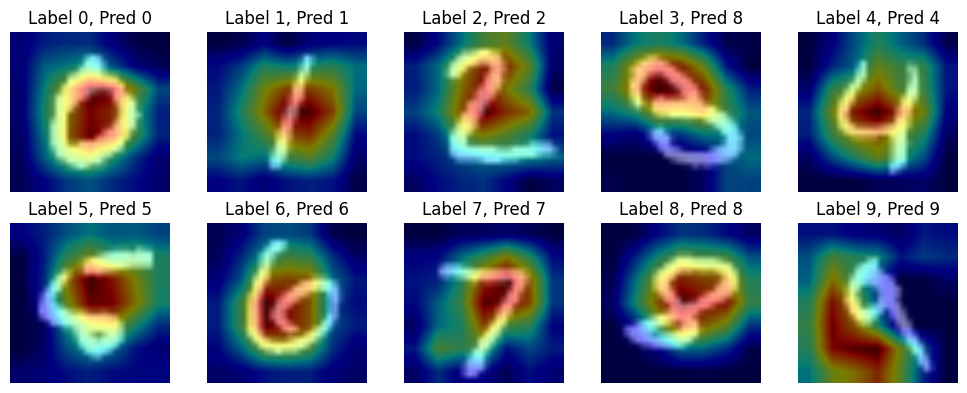


🔹 Running Normalized dataset


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/8] - Loss: 0.4969 | Train Acc: 89.26% | Val Acc: 94.83%
Epoch [2/8] - Loss: 0.1878 | Train Acc: 95.19% | Val Acc: 95.58%
Epoch [3/8] - Loss: 0.1472 | Train Acc: 96.08% | Val Acc: 96.48%
Epoch [4/8] - Loss: 0.1267 | Train Acc: 96.46% | Val Acc: 96.56%
Epoch [5/8] - Loss: 0.1147 | Train Acc: 96.78% | Val Acc: 96.48%
Epoch [6/8] - Loss: 0.1056 | Train Acc: 96.94% | Val Acc: 96.81%
Epoch [7/8] - Loss: 0.0998 | Train Acc: 97.09% | Val Acc: 97.01%
Epoch [8/8] - Loss: 0.0941 | Train Acc: 97.24% | Val Acc: 97.13%
✅ Normalized Test Accuracy: 96.83%


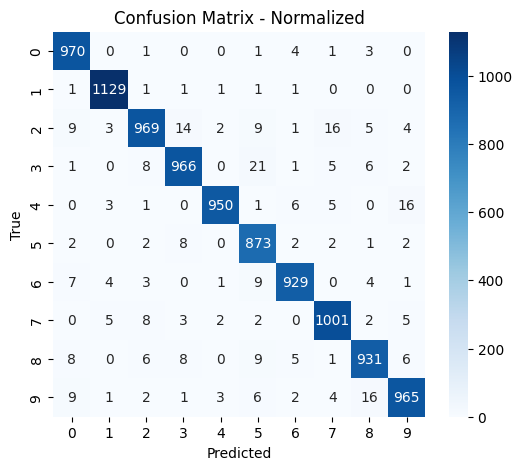

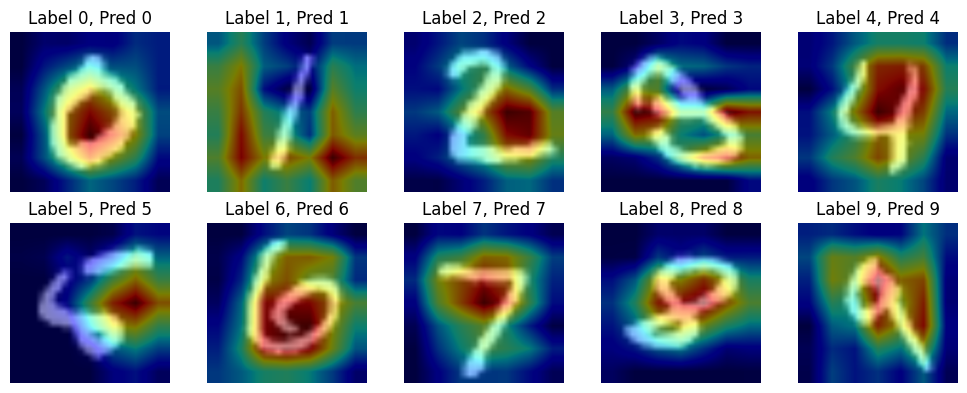


🔹 Running Normalized + Augment dataset


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/8] - Loss: 0.7206 | Train Acc: 81.56% | Val Acc: 89.03%
Epoch [2/8] - Loss: 0.3489 | Train Acc: 90.15% | Val Acc: 91.02%
Epoch [3/8] - Loss: 0.2871 | Train Acc: 91.55% | Val Acc: 92.17%
Epoch [4/8] - Loss: 0.2604 | Train Acc: 92.17% | Val Acc: 92.25%
Epoch [5/8] - Loss: 0.2420 | Train Acc: 92.62% | Val Acc: 92.64%
Epoch [6/8] - Loss: 0.2312 | Train Acc: 92.83% | Val Acc: 92.95%
Epoch [7/8] - Loss: 0.2229 | Train Acc: 92.97% | Val Acc: 93.12%
Epoch [8/8] - Loss: 0.2122 | Train Acc: 93.38% | Val Acc: 93.22%
✅ Normalized + Augment Test Accuracy: 92.87%


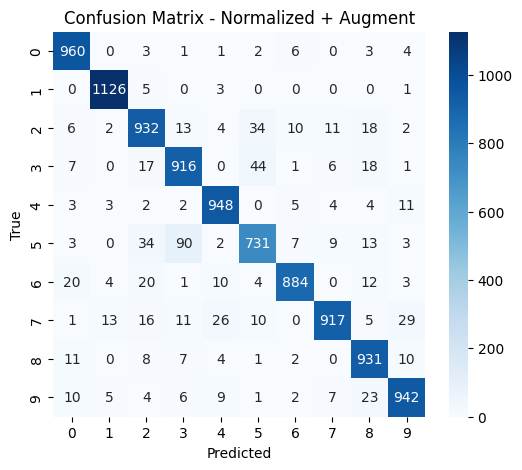

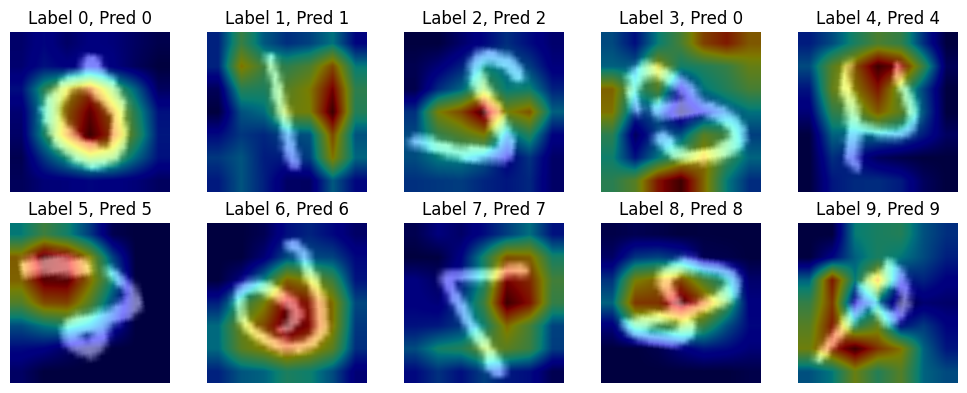


🔹 Running Normalized + Augment + Regularize dataset


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/8] - Loss: 0.9536 | Train Acc: 69.75% | Val Acc: 88.01%
Epoch [2/8] - Loss: 0.6324 | Train Acc: 79.27% | Val Acc: 89.87%
Epoch [3/8] - Loss: 0.6164 | Train Acc: 79.33% | Val Acc: 90.13%
Epoch [4/8] - Loss: 0.6025 | Train Acc: 79.65% | Val Acc: 90.30%
Epoch [5/8] - Loss: 0.5963 | Train Acc: 80.17% | Val Acc: 90.18%
Epoch [6/8] - Loss: 0.5985 | Train Acc: 79.99% | Val Acc: 90.81%
Epoch [7/8] - Loss: 0.6037 | Train Acc: 79.82% | Val Acc: 91.13%
Epoch [8/8] - Loss: 0.6007 | Train Acc: 79.69% | Val Acc: 90.33%
✅ Normalized + Augment + Regularize Test Accuracy: 90.55%


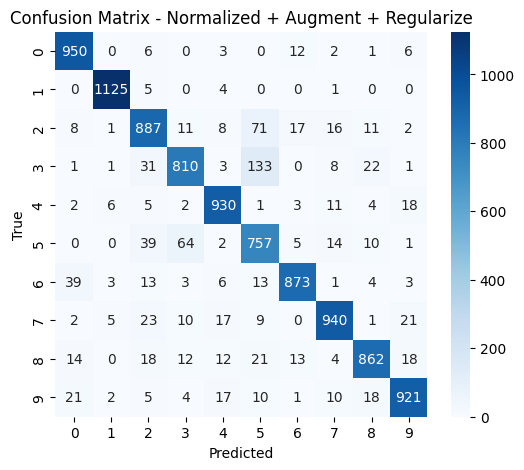

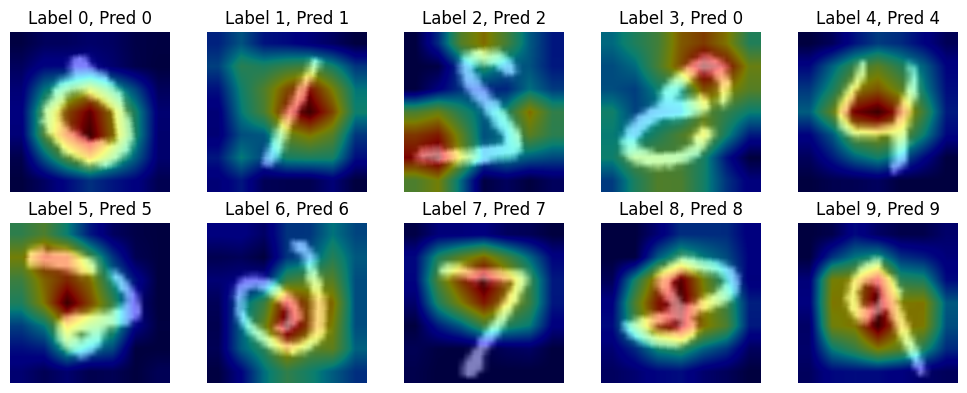

In [ ]:
# ---------------------------
# 4. RUN EXPERIMENTS
# ---------------------------

results = []
histories = {}  # store per-variation accuracy history

if os.path.exists("./feature_extraction_runs"):
    print("📂 Loading previous results...")
    with open("./feature_extraction_runs/results_featureextraction.pkl", "rb") as f:
        results, histories = pickle.load(f)
else:
    for variation_name, transform in transform_variations.items():
        print(f"\n🔹 Running {variation_name} dataset")

        # ---- Dataset split ----
        dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

        # ---- Model setup ----
        model = models.resnet18(pretrained=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Sequential(
            nn.Dropout(0.5 if "Regularize" in variation_name else 0.0),
            nn.Linear(model.fc.in_features, 10)
        )
        model = model.to(device)

        # ---- Train & Track ----
        history = {"train_loss": [], "train_acc": [], "val_acc": []}
        history = train_feature_extraction(
            model,
            train_loader,
            val_loader,
            epochs=10,
            lr=1e-4,
            regularize="Regularize" in variation_name,
            history=history
        )

        # ---- Evaluate on Test Set ----
        test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
        test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
        test_acc, preds, labels = evaluate(model, test_loader)
        print(f"✅ {variation_name} Test Accuracy: {test_acc:.2f}%")

        # ---- Confusion Matrix ----
        cm = confusion_matrix(labels, preds)
        classes = np.unique(labels)

        # Plot confusion matrix using seaborn for nice labels
        plt.figure(figsize=(7,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"Confusion Matrix - {variation_name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        # Print classification report per class and averages
        report = classification_report(labels, preds, target_names=[str(c) for c in classes])
        print(f"Classification Report for {variation_name}:\n{report}")

        # Extract key macro metrics
        prec = precision_score(labels, preds, average='macro')
        rec = recall_score(labels, preds, average='macro')
        f1 = f1_score(labels, preds, average='macro')
        acc = accuracy_score(labels, preds)

        print(f"Macro Precision: {prec:.4f}, Macro Recall: {rec:.4f}, Macro F1: {f1:.4f}, Accuracy: {acc:.4f}")

        # ---- Store results ----
        results.append({"Variation": variation_name, "Accuracy": test_acc})
        histories[variation_name] = history

        # ---- Grad-CAM Visualizations ----
        grad_cam = GradCAM(model, model.layer4[-1].conv2)
        fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
        axes_flat = axes.flatten()

        for i in range(10):
            ax = axes_flat[i]
            idx = np.where(np.array(test_dataset.targets) == i)[0][0]
            img, _ = test_dataset[idx]
            input_tensor = img.unsqueeze(0).to(device)
            input_tensor.requires_grad_()
            cam, cls = grad_cam.generate(input_tensor)
            cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1]))

            ax.imshow(img.squeeze().cpu().numpy(), cmap="gray")
            ax.imshow(cam_resized, cmap="jet", alpha=0.5)
            ax.set_title(f"Label {i}, Pred {cls}")
            ax.axis("off")

        plt.tight_layout()
        plt.show()
    #--- Save data ----
    print("\nSaving final results...")
    os.makedirs("./feature_extraction_runs", exist_ok=True)
    with open(f"./feature_extraction_runs/results_featureextraction.pkl", "wb") as f:
        pickle.dump((results, histories), f)
        


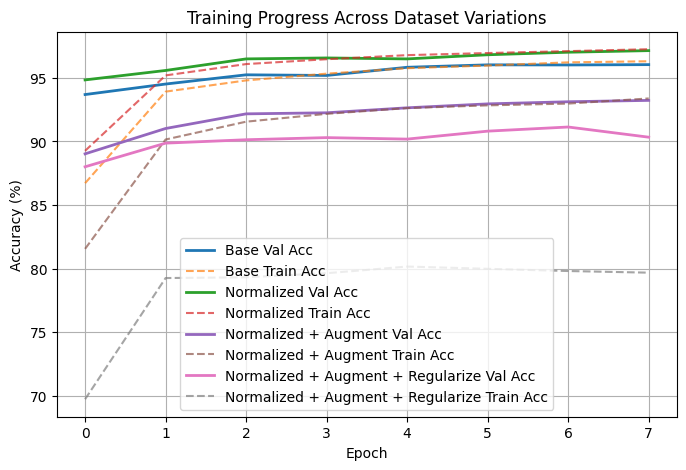

In [ ]:
# ---------------------------
# 5. TRAINING PROGRESS CURVES (Loss + Accuracy)
# ---------------------------
plt.figure(figsize = (15, 8))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
# Adapt labels to be simpler like the style, while keeping the variation logic
for variation_name, history in histories.items():
    plt.plot(history["train_acc"], linestyle="--", alpha=0.7, label=f"{variation_name} Train Acc")
    plt.plot(history["val_acc"], linewidth=2, label=f"{variation_name} Val Acc")

plt.xlabel ("epochs")
plt.ylabel ("accuracy")
plt.legend()

# Subplot 2: Loss
plt.subplot(1, 2, 2)
# Adapt labels to be simpler like the style
for variation_name, history in histories.items():
    plt.plot(history["train_loss"], linewidth=2, label=f"{variation_name} Loss")

plt.xlabel ("epochs")
plt.ylabel ("loss")
plt.legend()

plt.show()

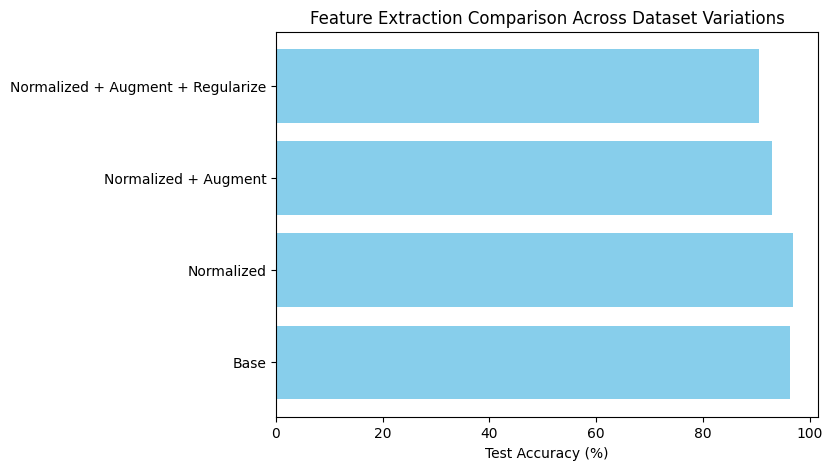

In [ ]:
# ---------------------------
# 6. FINAL COMPARISON (BAR CHART)
# ---------------------------

plt.figure(figsize=(7,5))
names = [r["Variation"] for r in results]
values = [r["Accuracy"] for r in results]
plt.bar(names,values,  color='skyblue')
plt.ylabel("Test Accuracy (%)")
plt.title("Feature Extraction Comparison Across Dataset Variations")
plt.show()